In [1]:
import sys
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import pandas as pd
import json
import numpy.fft
from decimal import Decimal
import math
import numpy as np
import matplotlib.pyplot as plt
from pyts.approximation import PAA
%matplotlib inline
# ASAP Simple (Brute Force)
def moving_average(data, _range):
    ret = np.cumsum(data, dtype=float)
    _range = int(_range)
    print(_range, "range")
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    slide = int(slide)
    ret = moving_average(data, _range)[::slide]
    return list(ret)

def kurtosis(values):
    return scipy.stats.kurtosis(values)

def roughness(vals):
    return np.std(np.diff(vals))

def smooth_simple(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    window_size = 1
    slide_size = 1
    if resolution:
        slide_size = int(len(data) // resolution)
        if slide_size > 1:
            data = SMA(data, slide_size, slide_size)
    orig_kurt   = kurtosis(data)
    min_obj     = roughness(data)
    for w in range(2, len(data) // max_window + 1):
        smoothed = SMA(data, w, 1)
        if kurtosis(smoothed) >= orig_kurt:
            r = roughness(smoothed)
            if r < min_obj:
                min_obj = r
                window_size = w
    return window_size, slide_size
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2 
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))    
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        self.correlations = R_t[:int(max_lag)].real / R_t[0].real
        
        # Find autocorrelation peaks 
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest 
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))
                    
def moving_average(data, _range):
    ret = np.cumsum(data)
    _range = int(_range)
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    slide = int(slide)
    _range = int(_range)
    ret = moving_average(data, _range)[::slide]
    return list(ret)
                    
def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

In [2]:
# Plot time series before and after smoothing
def plot(data, window_size, slide_size):
    plt.clf()
    plt.figure()
    data = SMA(data, slide_size, slide_size)
    print("Data size", len(data))
    method_names = ["Original", "Smoothed"]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    smoothed = SMA(data, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    ax1.set_xlim(0, len(data))
    ax1.plot(data, linestyle='-', linewidth=1.5)
    ax2.plot(smoothed_range, smoothed, linestyle='-', linewidth=1.5)
    axes = [ax1, ax2]
    for i in range(2):
        axes[i].get_xaxis().set_visible(False)
        axes[i].text(0.02, 0.8, "%s" %(method_names[i]),
            verticalalignment='center', horizontalalignment='left',
            transform=axes[i].transAxes, fontsize=25)

    fig.set_size_inches(16, 6)
    plt.tight_layout(w_pad=1)
    plt.show()
    return data

In [3]:
# Read data from CSV
def load_csv(fname, input_column=1):
    import csv
    with open(fname, 'r') as ifh:
        icsv = csv.reader(ifh)
        if sys.version_info.major == 2:
            header = icsv.next()
        else:
            header = next(icsv)
        rows = list(icsv)

        try:
            data = [ float(x[input_column]) for x in rows ]
        except ValueError:
            print("couldn't convert input-column={0} float".format(input_column))
            if rows:
                print("first row:")
                for idx,x in enumerate(rows[0]):
                    print('  column {:3d}: {}'.format(idx,x))
            exit(1)
    return data

[8767.0, 7005.0, 5257.0, 4189.0]
--- 0.005012989044189453 seconds ---
977


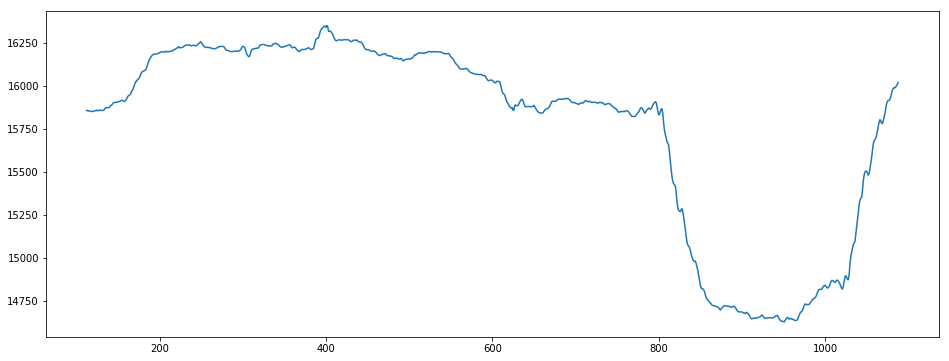

In [4]:
# Taxi
import sys
import time
import numpy as np
taxi_data = load_csv('Taxi.csv')
print(taxi_data[1:5])
start = time.time()
win_size, s_size = smooth_ASAP(taxi_data, resolution=1000)
#window_size, slide_size = smooth_simple(raw_data, resolution=1000)
data = SMA(taxi_data, s_size, s_size)
smoothed = SMA(data, win_size, 1)
smoothed_range = range(int(win_size/2), int(win_size/2) + len(smoothed))
end = time.time()
print("--- %s seconds ---" % (end - start))

print(len(smoothed))

#plot(taxi_data, win_size, s_size)

plt.figure(figsize=(16,6))
plt.plot(smoothed_range,smoothed)

#plt.axis('off')
#plt.title("ASAP")
#plt.savefig('window_taxi.pdf')
plt.show()

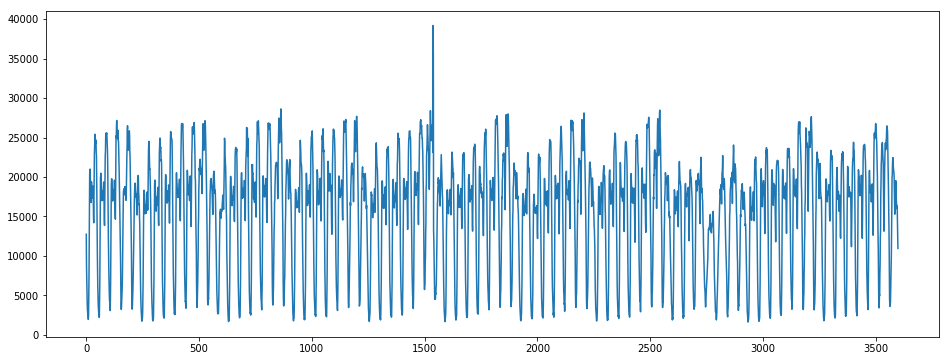

In [5]:
#Original
plt.figure(figsize=(16,6))
plt.plot(taxi_data)
#print(len(taxi_data["value"]))
#plt.title("Original")
#plt.savefig('original_taxi.pdf')
plt.show()

In [6]:
#Window Sampling (PASS)
import calendar

def toTimestamp(d):
  return calendar.timegm(d.timetuple())
def window_sample(data,theta = 5):
    y = "value"
    x = "x"
    if(len(data) <=2):
        return data
    ret = []
    first =  data.iloc[0]
    second = data.iloc[1]
    x1 = toTimestamp(first[x])
    x2 = toTimestamp(second[x])
    y1 = first[y]
    y2 = second[y]
    running_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
    current_angle = running_angle
    others = data.iloc[2:len(data)]
    ret.append(first)
    prev = second
    for index, current in others.iterrows():
        x1 = toTimestamp(prev[x])
        x2 = toTimestamp(current[x])
        y1 = prev[y]
        y2 = current[y]
        current_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
        #print("{0} {1} {2} {3} {4}".format(y1,y2,x1,x2,current_angle))
        if abs(current_angle - running_angle) > theta:
            running_angle = current_angle
            ret.append(prev)
            #ret.append(current)
        prev = current
    ret.append(prev)
    return ret
import calendar

import calendar

def toTimestamp(d):
  return calendar.timegm(d.timetuple())
def window_sample_p(data,theta = 5):
    y = "value"
    x = "x"
    if(len(data) <=2):
        return data
    ret = []
    first = data.iloc[0]
    second = data.iloc[1]
    x1 = first[x]
    x2 = second[x]
    y1 = first[y]
    y2 = second[y]
    running_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
    current_angle = running_angle
    others = data.iloc[2:len(data)]
    ret.append(first)
    prev = second
    for index, current in others.iterrows():
        x1 = prev[x]
        x2 = current[x]
        y1 = prev[y]
        y2 = current[y]
        current_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
        #print("{0} {1} {2} {3} {4}".format(y1,y2,x1,x2,current_angle))
        if abs(current_angle - running_angle) > theta:
            running_angle = current_angle
            ret.append(prev)
            #ret.append(current)
        prev = current
    ret.append(prev)
    return ret
t = 0
def window_sample_p(data,theta = 5):
    y = "value"
    x = "x"
    if(len(data) <=2):
        return data
    ret = []
    first = data.iloc[0]
    second = data.iloc[1]
    x1 = first[x]
    x2 = second[x]
    y1 = first[y]
    y2 = second[y]
    running_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
    current_angle = running_angle
    others = data.iloc[2:len(data)]
    ret.append(first)
    prev = second
    for index, current in others.iterrows():
        x1 = prev[x]
        x2 = current[x]
        y1 = prev[y]
        y2 = current[y]
        current_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)/60))
        #print("{0} {1} {2} {3} {4}".format(y1,y2,x1,x2,current_angle))
        if abs(current_angle - running_angle) > theta:
            running_angle = current_angle
            ret.append(prev)
            #ret.append(current)
        prev = current
    ret.append(prev)
    return ret
def fn(x):
    global t
    t = t + 1
    return t

--- 0.2929961681365967 seconds ---
796


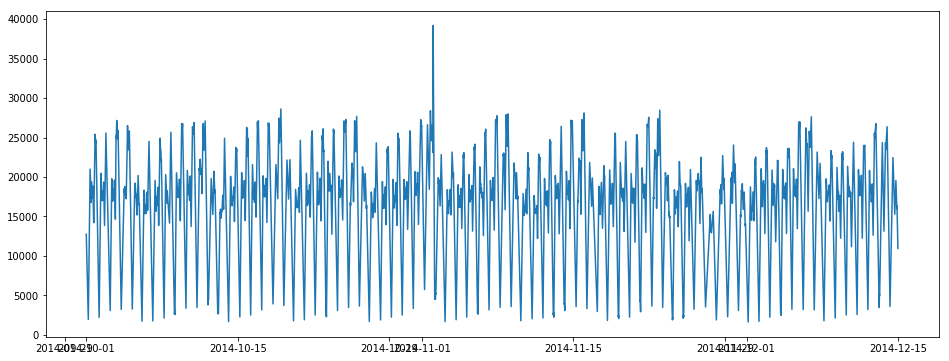

In [30]:
taxi_data = pd.read_csv('Taxi.csv')
taxi_data["x"] = taxi_data["timestamp"].apply(lambda x: pd.to_datetime(x))
taxi_data.head()
#taxi_data["value"] = taxi_data["value"]
#taxi_data["x"] = taxi_data["timestamp"].apply(lambda x : fn(x))
start = time.time()
sample = window_sample(taxi_data,163)
end = time.time()
print("--- %s seconds ---" % (end - start))


#sample = window_sample_p(taxi_data,167)
print(len(sample))
dframe = pd.DataFrame(sample)
x = np.array(dframe["x"])
y = np.array(dframe["value"])
plt.figure(figsize=(16,6))
plt.plot(x,y)
#plt.axis('off')
#plt.title("WinSamp")
#plt.savefig('window_taxi.pdf')
plt.show()

In [52]:
"""
import calendar

def toTimestamp(d):
  return calendar.timegm(d.timetuple())
def get_error(original, sample):
    error = 0.0
    samd = sample.copy()
    samd['Date'] = samd['Date'].apply(lambda x: toTimestamp(x))
    X = np.array(samd["Date"])
    Y = np.array(samd[col])
    for index, row in original.iterrows():
        time = toTimestamp(row["Date"])
        val = np.interp(time,X,Y)
        error += (row[col] - val)**2
    return error
start_err = get_error(data,df)
print(start_err)
"""
import calendar

def toTimestamp(d):
  return calendar.timegm(d.timetuple())
taxi_data.shape
len(sample)
taxi_x = taxi_data["x"].apply(lambda x : toTimestamp(x))
taxi_y = taxi_data["value"]
pass_x = dframe["x"].apply(lambda x : toTimestamp(x))
pass_y = dframe["value"]
#print(len(pass_x))
i = 0
dif = 0
maxv = 0
for x in taxi_x:
    val = np.interp(x, pass_x, pass_y)
    dif = max(dif, abs(val - taxi_y.iloc[i]))
    maxv = max(taxi_y.iloc[i], maxv)
    i = i + 1
print(dif, maxv)
for i in range(0, pass_y.shape[0]):
    print("{0} - {1} - {2} - {3}".format(taxi_y.iloc[i], pass_y.iloc[i], taxi_x.iloc[i], pass_x.iloc[i]))

16033.714285714286 39197
12751 - 12751 - 1412121600 - 1412121600
8767 - 1961 - 1412123400 - 1412137800
7005 - 20999 - 1412125200 - 1412152200
5257 - 16773 - 1412127000 - 1412161200
4189 - 19397 - 1412128800 - 1412163000
3236 - 17332 - 1412130600 - 1412168400
2817 - 18842 - 1412132400 - 1412173800
2527 - 14201 - 1412134200 - 1412181000
2406 - 25414 - 1412136000 - 1412191800
1961 - 24248 - 1412137800 - 1412197200
2478 - 24669 - 1412139600 - 1412199000
4483 - 2221 - 1412141400 - 1412224200
7002 - 20480 - 1412143200 - 1412238600
11917 - 17534 - 1412145000 - 1412244000
15929 - 17803 - 1412146800 - 1412245800
20327 - 16994 - 1412148600 - 1412247600
20974 - 18251 - 1412150400 - 1412251200
20999 - 17104 - 1412152200 - 1412254800
19639 - 19364 - 1412154000 - 1412260200
19221 - 13866 - 1412155800 - 1412267400
17308 - 25574 - 1412157600 - 1412278200
17140 - 3083 - 1412159400 - 1412312400
16773 - 19776 - 1412161200 - 1412325000
19397 - 16952 - 1412163000 - 1412332200
18697 - 18426 - 1412164800 - 1

In [66]:
passindices = {}
for i in range(0, pass_x.shape[0]):
    passindices[pass_x.iloc[i]] = i
taxiindices = {}
for i in range(0, taxi_x.shape[0]):
    taxiindices[taxi_x.iloc[i]] = i
dif = 0
difl = []
for x in taxiindices:
    if x not in passindices:
        val = np.interp(x, pass_x, pass_y)
        original = taxi_y.iloc[taxiindices[x]]
        dif = max(dif, abs(val - original))
        difl.append(abs(val - original))
print(dif)
#print(difl)
dif = 0
count = 0
#print(np.all(np.diff(pass_x) > 0))
for x in pass_x:
    dif = max(dif, abs(pass_y.iloc[passindices[x]] - taxi_y.iloc[taxiindices[x]]))
    count = count + 1
print(dif, count)

16033.714285714286
0 796


--- 0.006079912185668945 seconds ---
900


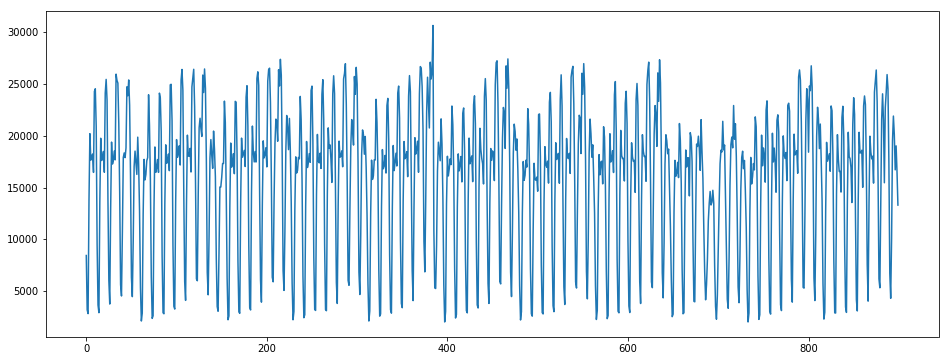

In [67]:
#PAA
start = time.time()
window_size = 4
paa = PAA(window_size=window_size)
X_paa = paa.transform([taxi_data["value"]])
end = time.time()
print("--- %s seconds ---" % (end - start))
print(len(X_paa[0]))
plt.figure(figsize=(16,6))
#plt.title("PAA(Window Size=4)")
plt.plot(X_paa[0])
plt.show()

In [68]:
X_paa[0]

array([ 8445.  ,  3192.25,  2832.  , 13793.75, 20208.25, 17654.5 ,
       17914.  , 18247.25, 16470.  , 24289.25, 24545.5 , 20892.25,
        9498.25,  3667.  ,  2922.5 , 13628.5 , 19767.75, 17620.  ,
       17800.5 , 18492.75, 16483.5 , 24122.25, 25448.5 , 23458.25,
       13811.5 ,  6044.5 ,  3758.5 , 12971.5 , 19394.75, 17273.75,
       17624.25, 18527.5 , 17681.75, 25956.5 , 25354.  , 25094.75,
       21181.5 , 14525.25,  5628.75,  4538.  , 10738.  , 17909.  ,
       18348.75, 17897.5 , 18830.5 , 24732.5 , 23872.5 , 25396.75,
       22978.75, 16184.5 ,  6356.5 ,  4472.  ,  9888.75, 17043.75,
       18526.75, 17384.25, 16277.  , 19871.75, 17250.75, 12728.5 ,
        5346.25,  2121.25,  2884.25, 12429.75, 17727.  , 15745.  ,
       16253.25, 17595.  , 17899.5 , 23968.  , 21023.25, 15812.25,
        6377.25,  2372.  ,  2624.  , 13011.5 , 18925.75, 16477.25,
       16956.75, 17712.  , 16470.75, 24122.5 , 23660.25, 20413.5 ,
        8410.  ,  2923.75,  2821.25, 13436.5 , 19131.25, 17342

1200


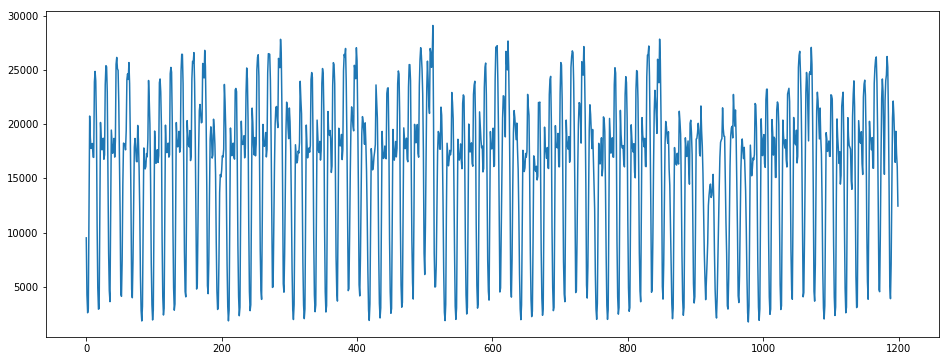

In [9]:
#PAA
window_size = 3
paa = PAA(window_size=window_size)
X_paa = paa.transform([taxi_data["value"]])

print(len(X_paa[0]))
plt.figure(figsize=(16,6))
#plt.title("PAA(Window Size=3)")
plt.plot(X_paa[0])
plt.show()

800
--- 1.1818366050720215 seconds ---
800


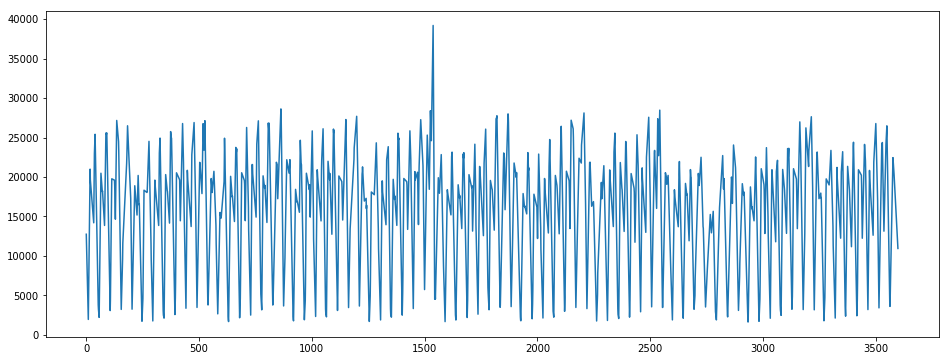

In [10]:
#M4

w = 200
print(4 * w)
taxi_data = pd.read_csv("Taxi.csv")
taxi_data.shape
taxi_data.head()


def m4(data, w):
    wsize = data.shape[0]//w
    ret = []
    seen = {}
    for g in range(0,w):
        maxv = None
        minv = None
        first = None
        last = None
        indices = [0,0,0,0]
        for i in range(g*wsize, g*wsize + wsize):
            if minv is None:
                minv = data.iloc[i]
                indices[0] = i
            elif data.iloc[i]["value"] < minv["value"]:
                minv = data.iloc[i]
                indices[0] = i
            if maxv is None:
                maxv = data.iloc[i]
                indices[1] = i
            elif data.iloc[i].value > maxv.value:
                maxv = data.iloc[i]
                indices[1] = i
            if i == g*wsize:
                first = data.iloc[i]
                indices[2] = i
            if i == g*wsize + wsize - 1:
                last = data.iloc[i]
                indices[3] = i
        indices.sort()
        for j in range(0, len(indices)):
            if indices[j] in seen:
                continue
            seen[j] = True
            ret.append(data.iloc[indices[j]])
    df = pd.DataFrame(ret)
    #df = df.sort_values("timestamp")
    return df


start = time.time()


ret = m4(taxi_data,w)
end = time.time()
print("--- %s seconds ---" % (end - start))

#M4

plt.figure(figsize=(16,6))
plt.plot(ret["value"])
print(len(ret["value"]))
fig = plt.gcf()
#plt.title("M4")
#plt.savefig('M4_taxi.pdf')
plt.show()

In [77]:
mx4 = ret["timestamp"].apply(lambda x: pd.to_datetime(x)).apply(lambda x : toTimestamp(x))
my4 = ret["value"]
passindices = {}
for i in range(0, mx4.shape[0]):
    passindices[mx4.iloc[i]] = i
taxiindices = {}
for i in range(0, taxi_x.shape[0]):
    taxiindices[taxi_x.iloc[i]] = i
dif = 0
difl = []
for x in taxiindices:
    if x not in passindices:
        val = np.interp(x, mx4, my4)
        original = taxi_y.iloc[taxiindices[x]]
        dif = max(dif, abs(val - original))
        difl.append(abs(val - original))
print(dif)
#print(difl)
dif = 0
count = 0
#print(np.all(np.diff(pass_x) > 0))
for x in mx4:
    dif = max(dif, abs(my4.iloc[passindices[x]] - taxi_y.iloc[taxiindices[x]]))
    count = count + 1
print(dif, count)

16839.666666666668
0 800


--- 1.2652337551116943 seconds ---
800


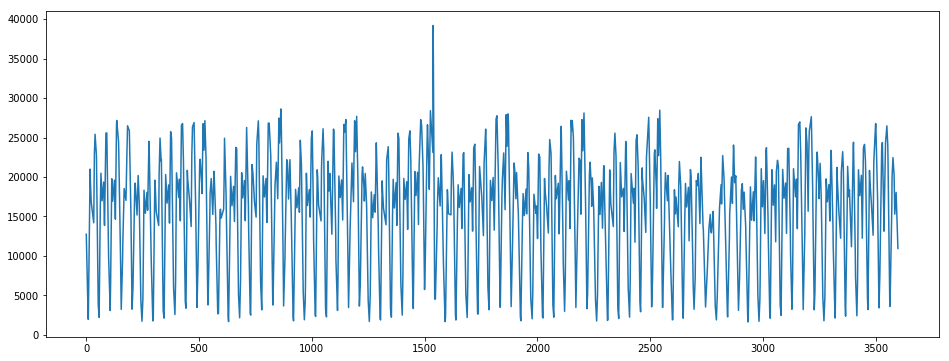

In [78]:
def minmax(data, w):
    wsize = data.shape[0]//w
    ret = []
    seen = {}
    for g in range(0,w):
        maxv = None
        minv = None
        indices = [0,0]
        for i in range(g*wsize, g*wsize + wsize):
            if minv is None:
                minv = data.iloc[i]
                indices[0] = i
            elif data.iloc[i]["value"] < minv["value"]:
                minv = data.iloc[i]
                indices[0] = i
            if maxv is None:
                maxv = data.iloc[i]
                indices[1] = i
            elif data.iloc[i].value > maxv.value:
                maxv = data.iloc[i]
                indices[1] = i
        indices.sort()
        for j in range(0, len(indices)):
            if indices[j] in seen:
                continue
            seen[j] = True
            ret.append(data.iloc[indices[j]])
    df = pd.DataFrame(ret)
    #df = df.sort_values("timestamp")
    return df
start = time.time()
ret = minmax(taxi_data,2*w)
end = time.time()
print("--- %s seconds ---" % (end - start))
#M4

plt.figure(figsize=(16,6))
plt.plot(ret["value"])
print(len(ret["value"]))
fig = plt.gcf()

#plt.title("Minmax")
#plt.savefig('M4_taxi.pdf')
plt.show()

<class 'pandas.core.frame.DataFrame'>
(828, 2)
--- 0.006839752197265625 seconds ---
828


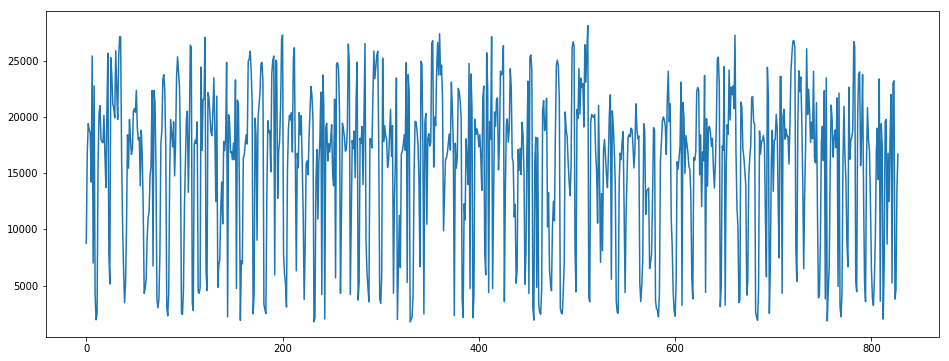

In [12]:
#Stratified
from datetime import datetime, date, time
data = taxi_data
import time
#print(data.shape)
#print(data.head())
col = "value"
great = datetime(2017,1,5,0,0)
#from time import sleep
#Stratified taxi Data
from sklearn.model_selection import StratifiedShuffleSplit
start = time.time()
sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - 0.23, random_state=0)
data = taxi_data
T = [0]*data.shape[0]
traini= sss.split(data,T)
D = pd.DataFrame()
for t,i in traini:
    print(type(data.iloc[t]))
    D = data.iloc[t]
#print(D)
print(D.shape)
D = D.sort_values(["timestamp"])
end = time.time()
print("--- %s seconds ---" % (end - start))
print(len(D))
x = np.array(D["timestamp"])
y = np.array(D[col])
plt.figure(figsize=(16,6))
plt.plot(y)
#plt.title("Stratified sampling")
#plt.savefig('stra.pdf')
plt.show()

--- 0.003451824188232422 seconds ---
792


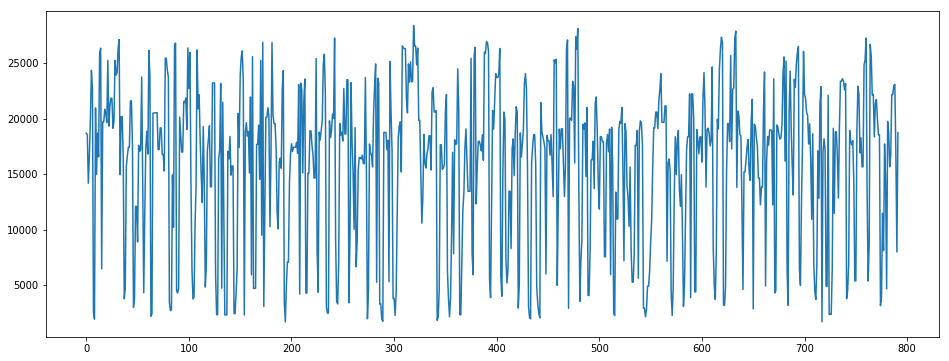

In [13]:
#Random Sampling Taxi Data
import time
start = time.time()
df = taxi_data.sample(frac=0.22, replace=True)
#print(taxi_data.head())
df = df.sort_values(["timestamp"])
end = time.time()
print("--- %s seconds ---" % (end - start))
print(len(df))
#x = np.array(df["timestamp"])
y = np.array(df["value"])
#print(df.head())
plt.figure(figsize=(16,6))
plt.plot(y)
#plt.title("Random sampling")
plt.show()

In [14]:
#SIMP(VW)

from rdp import rdp

rdp([[1, 1], [2, 2], [3, 3], [4, 4]])

[[1, 1], [4, 4]]

In [15]:
rdp([[1, 1], [1, 1.1], [2, 2]], epsilon=0.5)

[[1.0, 1.0], [2.0, 2.0]]

In [16]:
import numpy as np
from rdp import rdp
import calendar
taxi_data = pd.read_csv('Taxi.csv')
taxi_data["x"] = taxi_data["timestamp"].apply(lambda x: pd.to_datetime(x))
taxi_data.head()
def toTimestamp(d):
  return calendar.timegm(d.timetuple())
rdp(np.array([1, 1, 2, 2, 3, 3, 4, 4]).reshape(4, 2))
X = np.array(taxi_data['x'].apply(lambda x : toTimestamp(x)))
Y = np.array(taxi_data['value'])


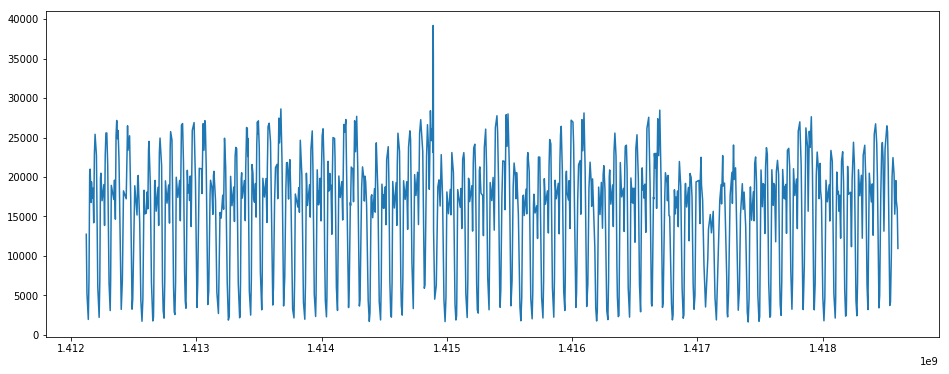

In [17]:
D = []

for i in range(0,len(X)):
    D.append([X[i],Y[i]])
start = time.time()
dp = rdp(D, epsilon = 1229)
end = time.time()
#print("--- %s seconds ---" % (end - start))
dframe = pd.DataFrame(dp)
#print(len(dp))
x = np.array(dframe[0])
y = np.array(dframe[1])
plt.figure(figsize=(16,6))
plt.plot(x,y)
#plt.title("RDP sampling")
plt.show()

--- 0.05506420135498047 seconds ---
800


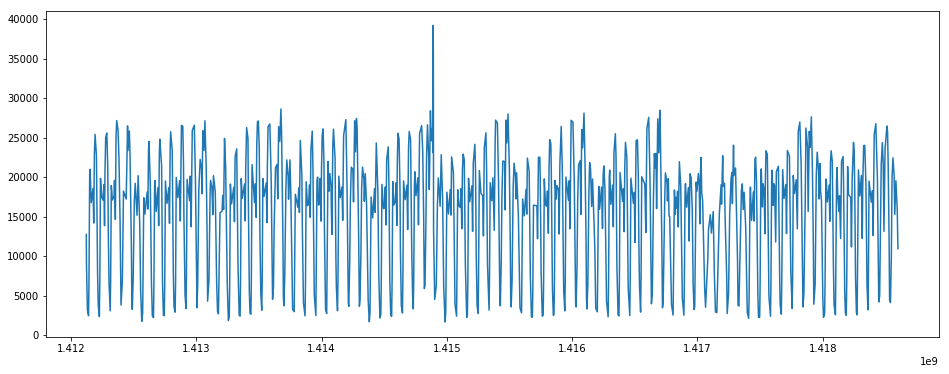

In [18]:
import visvalingamwyatt as vw
start = time.time()
D = []
for i in range(0,len(X)):
    D.append([X[i],Y[i]])
simplifier = vw.Simplifier(D)
vwd = simplifier.simplify(ratio = .222)
end = time.time()
print("--- %s seconds ---" % (end - start))

print(len(vwd))
dframe = pd.DataFrame(vwd)
x = np.array(dframe[0])
y = np.array(dframe[1])
plt.figure(figsize=(16,6))
plt.plot(x,y)
#plt.title("VWD sampling")
plt.show()

3600


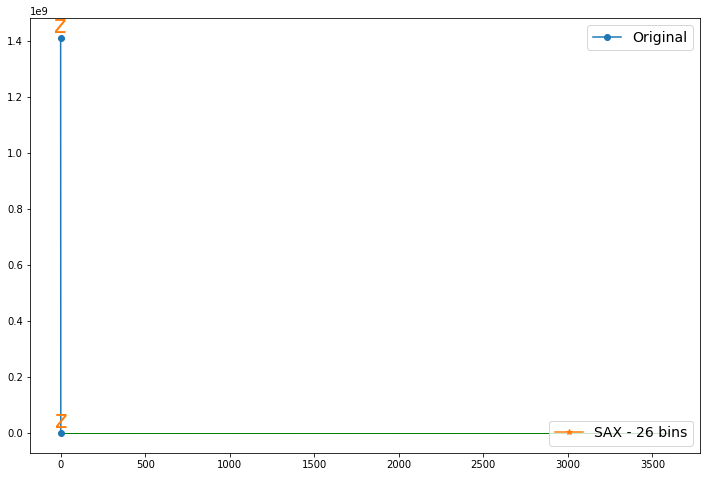

In [19]:
from pyts.quantization import SAX
from scipy.stats import norm
import matplotlib.lines as mlines

n_bins = 26
quantiles = 'gaussian'
sax = SAX(n_bins=n_bins, quantiles=quantiles)
X_sax = sax.fit_transform(D)
print(len(X_sax))
bins = norm.ppf(np.linspace(0, 1, n_bins + 1)[1:-1])
plt.figure(figsize=(12, 8))
plt.plot(D[0], 'o-', label='Original')
for x, y, s in zip(range(len(D)), D[0], X_sax[0]):
    plt.text(x, y, s, ha='center', va='bottom', fontsize=24, color='#ff7f0e')
plt.hlines(bins, 0, len(D), color='g', linestyles='--', linewidth=0.5)
sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                           label='SAX - {0} bins'.format(n_bins))
first_legend = plt.legend(handles=[sax_legend], fontsize=14, loc=4)
ax = plt.gca().add_artist(first_legend)
plt.legend(loc='best', fontsize=14)
plt.show()


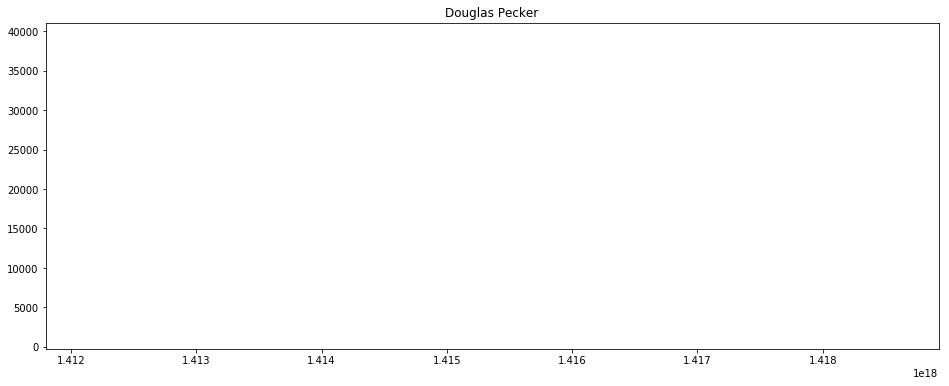

(1, 3600)

In [20]:
#Douglas Pecker
taxi_data = pd.read_csv('Taxi.csv')
taxi_data["x"] = taxi_data["timestamp"].apply(lambda x: pd.to_datetime(x))
taxi_data.head()
#taxi_data["value"] = taxi_data["value"]
#taxi_data["x"] = taxi_data["timestamp"].apply(lambda x : fn(x))
#sample = window_sample(taxi_data,163)
#sample = window_sample_p(taxi_data,167)
#print(len(sample))
dframe = pd.DataFrame(taxi_data)
#a = np.array(dframe["x"])
#b = np.array(dframe["value"])
plt.figure(figsize=(16,6))
a=np.array(rdp([np.array(dframe["x"])],epsilon=0.5))
b=np.array(rdp([np.array(dframe["value"])],epsilon=0.5))

#rdp(np.array([a])).size
#rdp(np.array([b])).size
#print(rdp(np.array([x]))))
#rdp([np.array(dframe["x"])],epsilon=0.5)
plt.plot(a,b)
# # #plt.axis('off') 
plt.title("Douglas Pecker")
# # #plt.savefig('window_taxi.pdf')
plt.show()

a.shape
b.shape

In [21]:
np.array([1, 1, 2, 2, 3, 3, 4, 4])
dframe["x"].ndim
np.array([1, 1, 2, 2, 3, 3, 4, 4]).ndim

1

In [22]:
import visvalingamwyatt as vw
points = [(1, 2), (2, 3), (3, 4)]
vw.simplify(points)

[[1, 2], [2, 3], [3, 4]]

In [23]:
#VW
taxi_data = pd.read_csv('Taxi.csv')
taxi_data["x"] = taxi_data["timestamp"].apply(lambda x: pd.to_datetime(x))
taxi_data.head()
#taxi_data["value"] = taxi_data["value"]
#taxi_data["x"] = taxi_data["timestamp"].apply(lambda x : fn(x))
#sample = window_sample(taxi_data,163)
#sample = window_sample_p(taxi_data,167)
#print(len(sample))
dframe = pd.DataFrame(taxi_data)
#a = np.array(dframe["x"])
#b = np.array(dframe["value"])
plt.figure(figsize=(16,6))
#a=np.array(rdp([np.array(dframe["x"])],epsilon=0.5))
#b=np.array(rdp([np.array(dframe["value"])],epsilon=0.5))

vw.simplify(dframe["x"],dframe["value"])

#rdp(np.array([a])).size
#rdp(np.array([b])).size
#print(rdp(np.array([x]))))
#rdp([np.array(dframe["x"])],epsilon=0.5)
# plt.plot(a,b)
# # # #plt.axis('off') 
# plt.title("VW")
# # # #plt.savefig('window_taxi.pdf')
# plt.show()

# a.shape
# b.shape

TypeError: 'Timestamp' object is not iterable

<Figure size 1152x432 with 0 Axes>

In [ ]:
#  prints a list of coordinate pairs
import csv
 
# Set up input and output variables for the script
taxi = open("Taxi.csv", "r")
 
# Set up CSV reader and process the header
csvReader = csv.reader(taxi) 
#taxi_data = pd.read_csv('Taxi.csv')
header = next(csvReader)
xIndex = header.index("timestamp")
vaueIndex = header.index("value")
 
# Make an empty list
coordList = []
 
# Loop through the lines in the file and get each coordinate
for row in csvReader:
    x = row[xIndex].replace('/', '').replace(':', '')
    value = row[vaueIndex]
    coordList.append([x,value])
 
# Print the coordinate list
#print (coordList)
len(coordList)
#vw.simplify(coordList)

rdp([coordList])

#plt.plot(np.array[rdp([coordList])])
# # #plt.axis('off') 
plt.title("Douglas Pecker")
# # #plt.savefig('window_taxi.pdf')
plt.show()

In [ ]:
import visvalingamwyatt as vw
start = time.time()
D = []
for i in range(0,len(X)):
    D.append([X[i],Y[i]])
simplifier = vw.Simplifier(D)
vwd = simplifier.simplify(ratio = .222)
end = time.time()
#print("--- %s seconds ---" % (end - start))

#print(len(vwd))
dframe = pd.DataFrame(vwd)
x = np.array(dframe[0])
y = np.array(dframe[1])
plt.figure(figsize=(16,6))
plt.plot(x,y)
#plt.title("VWD sampling")
plt.show()